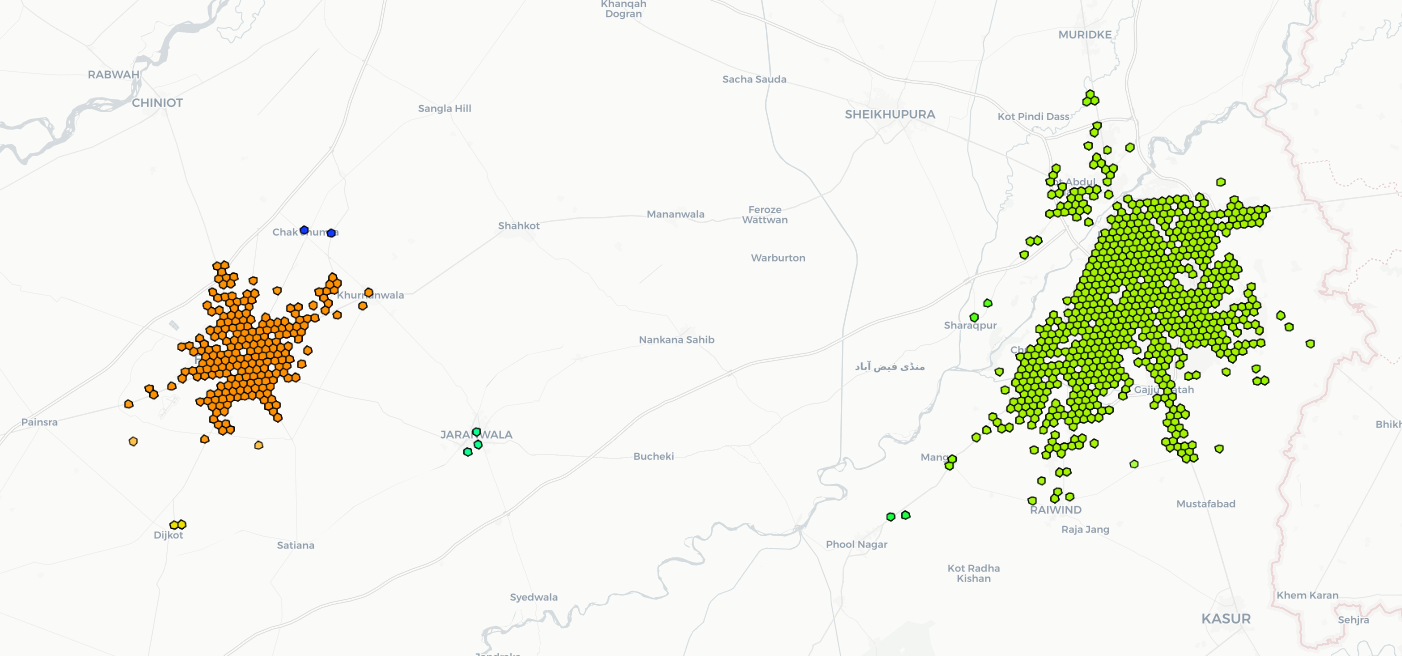

In [193]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd

import h3

import h3
import numpy as np
from scipy.spatial.distance import cosine

from geojson import Feature, Point, FeatureCollection

import numpy as np

import matplotlib

import json

import networkx as nx

from tqdm import tqdm

from math import*

import folium
import geojson

In [31]:
def to_h3(lat, lon, res):
    return h3.geo_to_h3(lat=lat, lng=lon, resolution=res)

def square_rooted(x):

    return round(sqrt(sum([a*a for a in x])),3)

def cosine_similarity(x,y):

    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    
    return round(numerator/float(denominator),3)

def hexagons_dataframe_to_geojson(df_hex, file_output = None, hex_col='h3_3', column_name = "value"):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        try:
            geometry_for_row = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row[hex_col],geo_json=True)]}
            feature = Feature(geometry = geometry_for_row , id=row[hex_col], properties = {column_name : row[column_name]})
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row[hex_col]) 

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result

def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))

def choropleth_map(df_aggreg, column_name = "value", hex_col='h3_3', border_color = 'black', fill_opacity = 0.7, color_map_name = "Blues", initial_map = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """    
    #colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    print(f"Colour column min value {min_value}, max value {max_value}, mean value {mean_value}")
    print(f"Hexagon cell count: {df_aggreg[hex_col].nunique()}")
    
    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)
    
    if initial_map is None:
        initial_map = folium.Map(location= [0, 0], zoom_start=2, tiles="cartodbpositron")

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg,hex_col=hex_col, column_name = column_name)

    # color_map_name 'Blues' for now, many more at https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    return initial_map

## load data

In [24]:
df = pd.read_csv(r"D:\Work\Data\House_Price_dataset.csv")

In [25]:
df

property_id  location_id  \
0            237062         3325   
1            346905         3236   
2            386513          764   
3            656161          340   
4            841645         3226   
...             ...          ...   
168441     17355248         6754   
168442     17355249          680   
168443     17355250         6757   
168444     17355251         6752   
168445     17355287        10045   

                                                 page_url property_type  \
0       https://www.zameen.com/Property/g_10_g_10_2_gr...          Flat   
1       https://www.zameen.com/Property/e_11_2_service...          Flat   
2       https://www.zameen.com/Property/islamabad_g_15...         House   
3       https://www.zameen.com/Property/islamabad_bani...         House   
4       https://www.zameen.com/Property/dha_valley_dha...         House   
...                                                   ...           ...   
168441  https://www.zameen.com/Property/gulshan_e_maym...         House   
168442  https://www.zameen.com/Property/gadap_town_gul...         House   
168443  https://www.zameen.com/Property/gulshan_e_maym...         House   
168444  https://www.zameen.com/Property/gulshan_e_maym...         House   
168445  https://www.zameen.com/Property/bahria_town_ka...         House   

           price             location       city      province_name  \
0       10000000                 G-10  Islamabad  Islamabad Capital   
1        6900000                 E-11  Islamabad  Islamabad Capital   
2       16500000                 G-15  Islamabad  Islamabad Capital   
3       43500000            Bani Gala  Islamabad  Islamabad Capital   
4        7000000          DHA Defence  Islamabad  Islamabad Capital   
...          ...                  ...        ...                ...   
168441  26500000           Gadap Town    Karachi              Sindh   
168442  12500000           Gadap Town    Karachi              Sindh   
168443  27000000           Gadap Town    Karachi              Sindh   
168444  11000000           Gadap Town    Karachi              Sindh   
168445   9000000  Bahria Town Karachi    Karachi              Sindh   

         latitude  longitude  baths       area   purpose  bedrooms  \
0       33.679890  73.012640      2    4 Marla  For Sale         2   
1       33.700993  72.971492      3  5.6 Marla  For Sale         3   
2       33.631486  72.926559      6    8 Marla  For Sale         5   
3       33.707573  73.151199      4    2 Kanal  For Sale         4   
4       33.492591  73.301339      3    8 Marla  For Sale         3   
...           ...        ...    ...        ...       ...       ...   
168441  25.029909  67.137192      0  9.6 Marla  For Sale         6   
168442  25.017951  67.136393      0    8 Marla  For Sale         3   
168443  25.015384  67.116330      0  9.6 Marla  For Sale         6   
168444  25.013265  67.120818      0  7.8 Marla  For Sale         3   
168445  25.113565  67.353811      3  9.4 Marla  For Sale         3   

        date_added                      agency  \
0       02-04-2019                         NaN   
1       05-04-2019                         NaN   
2       07-17-2019                         NaN   
3       04-05-2019                         NaN   
4       07-10-2019               Easy Property   
...            ...                         ...   
168441  07-18-2019       Al Shahab Enterprises   
168442  07-18-2019       Al Shahab Enterprises   
168443  07-18-2019       Al Shahab Enterprises   
168444  07-18-2019       Al Shahab Enterprises   
168445  07-18-2019  ZPN Real Estate & Builders   

                                               agent Area Type  Area Size  \
0                                                NaN     Marla        4.0   
1                                                NaN     Marla        5.6   
2                                                NaN     Marla        8.0   
3                                                NaN     Kanal        2

### munge the data

In [30]:
sw = (df['latitude'].min(), df['longitude'].min())
ne = (df['latitude'].max(), df['longitude'].max())

In [32]:
df['h3_8'] = df.apply(lambda row: to_h3(row['latitude'], row['longitude'], res=8), axis=1)

In [33]:
df.iloc[1].T

property_id                                                 346905
location_id                                                   3236
page_url         https://www.zameen.com/Property/e_11_2_service...
property_type                                                 Flat
price                                                      6900000
location                                                      E-11
city                                                     Islamabad
province_name                                    Islamabad Capital
latitude                                                 33.700993
longitude                                                72.971492
baths                                                            3
area                                                     5.6 Marla
purpose                                                   For Sale
bedrooms                                                         3
date_added                                              05-04-

In [34]:
df = df[['h3_8', 'price', 'bedrooms','baths']]

df = df.groupby('h3_8').mean().reset_index()

df['features'] = df.apply(lambda row: (row['price'], row['bedrooms'], row['baths']), axis=1)

In [41]:
df

h3_8         price  bedrooms     baths  \
0     88019c9905fffff  8.000000e+06  0.000000  4.000000   
1     880b4db6b7fffff  3.600000e+07  4.500000  4.500000   
2     88106506edfffff  1.100000e+04  0.000000  0.000000   
3     88106c7765fffff  2.000000e+04  0.000000  0.000000   
4     8811560f17fffff  3.000000e+06  2.000000  2.000000   
...               ...           ...       ...       ...   
2243  8842e47b33fffff  7.850029e+07  3.529412  2.117647   
2244  8842e47b3dfffff  4.000000e+06  2.000000  2.000000   
2245  8842e47b65fffff  1.989167e+07  2.416667  2.500000   
2246  8842e6b607fffff  8.742857e+06  4.285714  4.428571   
2247  886a2426b9fffff  6.000000e+04  3.000000  3.000000   

                                               features  
0                                 (8000000.0, 0.0, 4.0)  
1                                (36000000.0, 4.5, 4.5)  
2                                   (11000.0, 0.0, 0.0)  
3                                   (20000.0, 0.0, 0.0)  
4                                 (3000000.0, 2.0, 2.0)  
...                                                 ...  
2243  (78500294.11764705, 3.5294117647058822, 2.1176...  
2244                              (4000000.0, 2.0, 2.0)  
2245      (19891666.666666668, 2.4166666666666665, 2.5)  
2246  (8742857.142857144, 4.285714285714286, 4.42857...  
2247                                (60000.0, 3.0, 3.0)  

[2248 rows x 5 columns]


## Do the thing
________

In [185]:
mydict = {}

In [186]:
for index, row in df.iterrows():
    mydict[row['h3_8']] = row['features']

In [188]:
G = nx.Graph()

threshold = .5

k=6
for current_hex_id in tqdm(mydict.keys()):

    neighbors = h3.k_ring(current_hex_id, k)
    
    neighbors.remove(current_hex_id)
    
    x = mydict[current_hex_id]
    for neighbor_hex_id in neighbors:
        try:
            y = mydict[neighbor_hex_id]
            similarity = cosine_similarity(x,y)
#             print(similarity)
            if similarity > threshold:
                G.add_edge(current_hex_id, neighbor_hex_id)
        except:
            continue

100%|████████████████████████████████████████████████████████████████████████████| 2248/2248 [00:01<00:00, 2140.37it/s]


In [189]:
df2 = pd.DataFrame()

mydict2 = dict()

cluster_num = 0
for cluster in list(nx.connected_components(G)):
    mydict2[cluster_num] = str(cluster)
    cluster_num += 1

In [190]:
df2 = pd.DataFrame(mydict2, index=mydict2.keys()).T[0]

df2 = pd.DataFrame(df2).rename(columns={0:'Node'})

df2 = pd.DataFrame(df2['Node'].apply(lambda x: list(eval(x))).explode()).reset_index().rename(columns={'index':'Cluster'})

In [194]:
resolution=8

m = folium.Map(tiles="cartodbpositron")
m.fit_bounds([sw, ne]) 

choropleth_map(df_aggreg=df2, column_name = "Cluster", hex_col=f'Node', border_color = 'black', fill_opacity = 0.7, color_map_name = "gist_rainbow", initial_map = m)

Colour column min value 0, max value 13, mean value 4.9855399909624944
Hexagon cell count: 2213


In [115]:
mydict2

{}

# Pyvis Graphic
_____

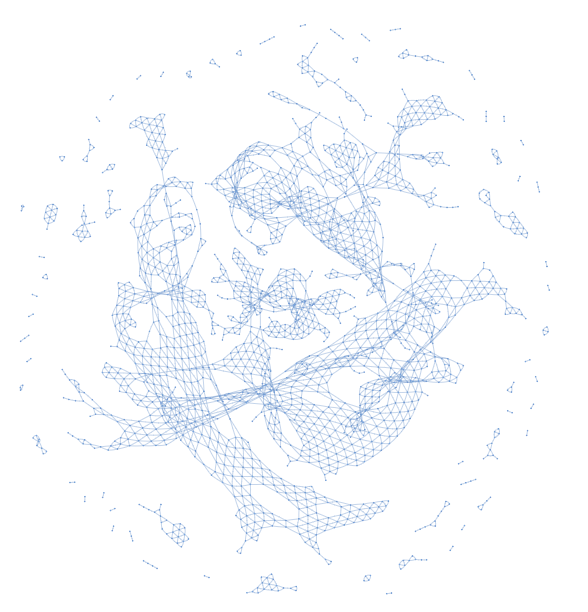

In [109]:
from pyvis.network import Network

In [195]:
nt = Network('1000px', '1000px')
nt.from_nx(G)
nt.show('nx.html')

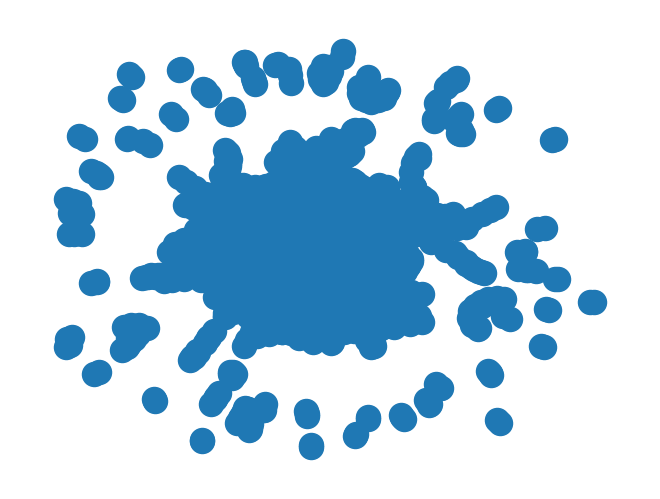

In [108]:
nx.draw(G)